# Cross-repetition dtw

* Idea: we need strong positive examples for training repetition detection
* Approach
  * Get labeled segmentations
  * For each track, and each pair of sections within a track, run dtw
  * See if we can threshold the dtw cost to determine whether or not two sections are repetitions of one-another
  * If so, take the path as a set of ground-truth positives
  * Sample negatives iid at random
  * win everything
  
* Extensions
  * In the downstream classifier, use *windows* of beat-sync features
  * That way we can get some smoothing and local context

In [3]:
import librosa
import dtw
import matplotlib.pyplot as plt
import seaborn
seaborn.set(style='dark')
%matplotlib inline

import numpy as np
import scipy
import mir_eval

In [4]:
def lab_to_aud(fname):
    
    fname = fname.replace('seglab_tut', 'audio')
    fname = fname.replace('.lab', '.flac')
    
    return fname

In [5]:
def make_cost_matrix(audio_file, intervals, labels):
    
    y, sr = librosa.load(audio_file)
    
    cqgram = librosa.logamplitude(librosa.cqt(y, sr=sr)**2)
    cqgram = scipy.stats.zscore(cqgram, axis=1)
    
    # convert intervals to frames
    intframes = librosa.time_to_frames(intervals)
    
    tempo, beats = librosa.beat.beat_track(y=y, sr=sr, trim=False)
    
    # Sub-divide
    subseg = librosa.segment.subsegment(cqgram, beats)
    subseg = librosa.util.fix_frames(subseg, x_min=0, x_max=cqgram.shape[1])
    
    # Synchronize
    cqgram = librosa.feature.sync(cqgram, subseg, aggregate=np.median)
    
    # Match intervals to subseg points
    intframes = librosa.util.match_events(intframes, subseg)

    D = np.zeros((len(labels), len(labels)))
    
    for i in range(len(labels)):
        x_slice = cqgram[:, intframes[i, 0]:intframes[i, 1]].T
        for j in range(i+1, len(labels)):
            y_slice = cqgram[:, intframes[j, 0]:intframes[j, 1]].T
            try:
                dtw_cost, distance, path = dtw.dtw(x_slice, y_slice)
                D[i, j] = dtw_cost
                #D[i, j] /= max([np.diff(intervals[j]), np.diff(intervals[i])])
                #D[i, j] = np.mean(np.abs(path[1] - path[0]))
            except:
                D[i, j] = np.nan
            
            D[j, i] = D[i, j]
            
    return D, labels

In [6]:
lab_files = librosa.util.find_files('/Volumes/Audio/datasets/Beatles_final/', ext='lab')

In [7]:
k = 151
lab_files[k]
audio_file = lab_to_aud(lab_files[k])
intervals, labels = mir_eval.io.load_labeled_intervals(lab_files[k])

In [11]:
D, labels = make_cost_matrix(audio_file, intervals, labels)

IOError: [Errno 2] No such file or directory: '/Volumes/Audio/datasets/Beatles_final/12_-_Abbey_Road/01_-_Come Together.flac'

In [193]:
from IPython.html.widgets import interact

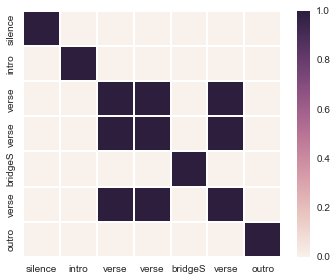

In [194]:
@interact(threshold=(0, D.max(), D.max()//50))
def _plot(threshold=0):
    plt.figure(figsize=(5,4))
    seaborn.heatmap((D<threshold), xticklabels=labels, yticklabels=labels)
    plt.tight_layout()